### Installing Libraries

In [ ]:
!pip install swifter
!pip install transformers
!pip install sacremoses

### Importing Packages

In [ ]:
import re
import re
import html
import string
import swifter
import pandas as pd
import unicodedata
from nltk.tokenize import word_tokenize

import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.models import load_model

import torch

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on GPU")
else:
    device = torch.device("cpu")
    print("Training on CPU")

Training on GPU


### Preparing Dataset for Image Captioning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_excel("/content/drive/MyDrive/Medical_Image_Captioning/output.xlsx")
df.head()

,Unnamed: 0,IMAGEORGAN,EVALUATION,QUESTION,Q_REPHASE,Q_RELATION,Q_FRAMED,Q_TYPE,ANSWER,A_TYPE,image_data,condition,description,links
0,0,head,not evaluated,are regions of the brain infarcted?,NaN,NaN,NaN,pres,yes,closed,synpic54610.jpg,multiple cerebral infarcts secondary to severe...,multiple small infarcts showing reduced diffus...,https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...
1,1,chest,not evaluated,are the lungs normal appearing?,NaN,NaN,NaN,abn,no,closed,synpic29265.jpg,left lower lobe pneumonia,dense airspace consolidation of the superior s...,https://medpix.nlm.nih.gov/case?id=b197277b-69...
2,2,chest,not evaluated,is there evidence of a pneumothorax,NaN,NaN,NaN,pres,no,closed,synpic29265.jpg,left lower lobe pneumonia,dense airspace consolidation of the superior s...,https://medpix.nlm.nih.gov/case?id=b197277b-69...
3,3,chest,given,what type of imaging does this not represent?,NaN,NaN,NaN,modality,ultrasound,open,synpic28602.jpg,pulmonary arteriovenous malformation,there are multiple nodular opacities with a lo...,https://medpix.nlm.nih.gov/case?id=19aa8a2b-35...
4,4,chest,given,is this a mri of the chest?,NaN,NaN,NaN,modality,no,closed,synpic29265.jpg,left lower lobe pneumonia,dense airspace consolidation of the superior s...,https://medpix.nlm.nih.gov/case?id=b197277b-69...


In [ ]:
data = df[["image_data","description"]]
dir_path = "/content/drive/MyDrive/Medical_Image_Captioning/pic"
data["image_path"] = data["image_data"].apply(lambda x: os.path.join(dir_path,x))
data.drop_duplicates(inplace=True)
data.drop("image_data", axis=1,inplace=True)
# data["description"] = df["description"]
data['description'] = data['description'].apply(lambda x: x if isinstance(x, str) else None)
data = data.dropna()
data.head()

<ipython-input-34-7870225ff858>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["image_path"] = data["image_data"].apply(lambda x: os.path.join(dir_path,x))
<ipython-input-34-7870225ff858>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)
<ipython-input-34-7870225ff858>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop("image_data"

,image_path,description
0,/content/drive/MyDrive/Medical_Image_Captionin...,multiple small infarcts showing reduced diffus...
1,/content/drive/MyDrive/Medical_Image_Captionin...,dense airspace consolidation of the superior s...
3,/content/drive/MyDrive/Medical_Image_Captionin...,there are multiple nodular opacities with a lo...
8,/content/drive/MyDrive/Medical_Image_Captionin...,axial t2 weighted image demonstrates increased...
10,/content/drive/MyDrive/Medical_Image_Captionin...,pa and lateral chest radiographs two weeks bef...


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Download NLTK resources (if you haven't already)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def text_preprocess(question):
    # Convert to lowercase
    text = str(question).lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join the tokens back into a clean text
    clean_text = " ".join(lemmatized_tokens)

    return(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data['description'] = data['description'].swifter.apply(text_preprocess)
data.head()

Pandas Apply:   0%|          | 0/313 [00:00<?, ?it/s]

,image_path,description
0,/content/drive/MyDrive/Medical_Image_Captionin...,multiple small infarct showing reduced diffusi...
1,/content/drive/MyDrive/Medical_Image_Captionin...,dense airspace consolidation superior segment lll
3,/content/drive/MyDrive/Medical_Image_Captionin...,multiple nodular opacity lobular outline right...
8,/content/drive/MyDrive/Medical_Image_Captionin...,axial t2 weighted image demonstrates increased...
10,/content/drive/MyDrive/Medical_Image_Captionin...,pa lateral chest radiograph two week patient p...


In [ ]:
for index_label, row_series in data.iterrows():
  data.at[index_label , 'description'] = 'startseq ' + row_series['description'] + ' endseq'

### Preparing Dictionary and fitting tokenizer

In [ ]:
all_captions = []
for index, row in data.iterrows():
  all_captions.append(row.description)

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

1502


In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
print(max_length)

121


### Extracting Features from Images

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# extract features from image
features = {}

for img_path in tqdm(data["image_path"]):
    # load the image from file
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)

    # # get image ID
    image_id = img_path.split('/')[-1]
    # store feature
    features[image_id] = feature

  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
WORKING_DIR='/content/drive/MyDrive/Medical_Image_Captioning/feature_file'
pickle.dump(features, open(os.path.join(WORKING_DIR, 'clef_features_vgg.pkl'), 'wb'))

In [ ]:
# load features from pickle
WORKING_DIR='/content/drive/MyDrive/Medical_Image_Captioning/feature_file'
with open(os.path.join(WORKING_DIR, 'clef_features_vgg.pkl'), 'rb') as f:
#with open(os.path.join('../input/picklesss/features.pkl'), 'rb') as f:
    features = pickle.load(f)

### Mapping Image Features to Image Names

In [ ]:
df_use = pd.DataFrame()
df_use['ID'] = data['image_path'].apply(lambda x: x.split("/")[-1])
df_use["clean_caption"] = data["description"]
df_use.head()

,ID,clean_caption
0,synpic54610.jpg,startseq multiple small infarct showing reduce...
1,synpic29265.jpg,startseq dense airspace consolidation superior...
3,synpic28602.jpg,startseq multiple nodular opacity lobular outl...
8,synpic39460.jpg,startseq axial t2 weighted image demonstrates ...
10,synpic42202.jpg,startseq pa lateral chest radiograph two week ...


In [ ]:
mapping=df_use.set_index('ID').T.to_dict('list')

In [ ]:
for key, value in mapping.items():
    print(key, ' : ', value)

synpic54610.jpg  :  ['startseq multiple small infarct showing reduced diffusion including right mca right pica left aca territory small suggestive slowflow instead branch occlusion endseq']
synpic29265.jpg  :  ['startseq dense airspace consolidation superior segment lll endseq']
synpic28602.jpg  :  ['startseq multiple nodular opacity lobular outline right lung base right upper lung right heart boarder partially obscured silhouetted consistent underlying cystic change bronchiectasis seen ct examination patient also mild biapical pleural thickening endseq']
synpic39460.jpg  :  ['startseq axial t2 weighted image demonstrates increased signal intensity swelling gray matter left temporal lobe mild mass effect evidenced effacement ambient cistern left medial temporal lobe midbrain additionally mild increased signal intensity right medial temporal lobe endseq']
synpic42202.jpg  :  ['startseq pa lateral chest radiograph two week patient presentation demonstrate interval widening mediastinum en

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

### Modeling

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            feature_key = key  #.split('.')[0]
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    #print([key])
                    X1.append(features[feature_key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

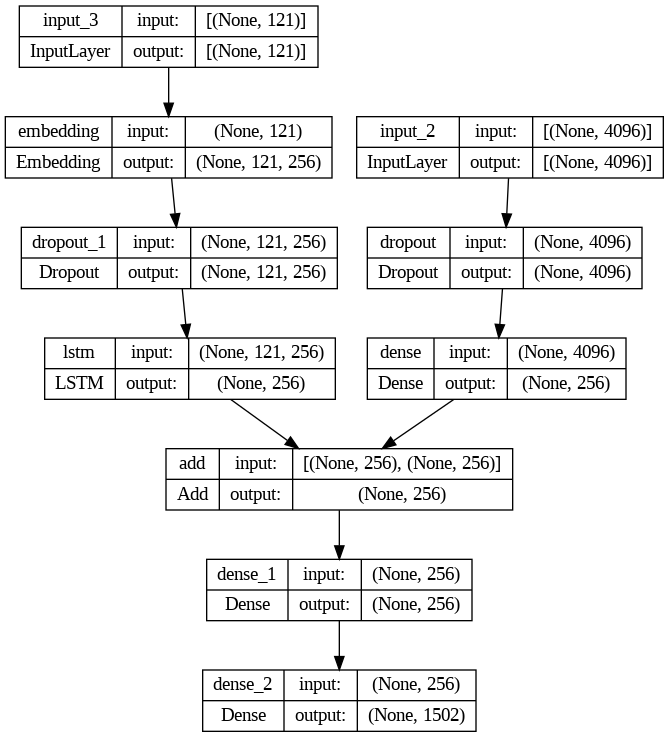

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["accuracy"])

# plot the model
plot_model(model, show_shapes=True)

### Training the Model

In [ ]:
# train the model
epochs = 50
batch_size = 16
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for 10 epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

15/15 [==============================] - 5s 322ms/step - loss: 0.4458 - accuracy: 0.8885


In [ ]:
WORKING_DIR='/content/drive/MyDrive/Medical_Image_Captioning/caption_model'
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [ ]:
# #Loading the trained Model
WORKING_DIR='/content/drive/MyDrive/Medical_Image_Captioning/caption_model'
loaded_model = load_model(WORKING_DIR+'/best_model.h5')

### Image Captioning Model Inference Functions

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
#generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

### Generate Your Inference

In [ ]:
# load features from pickle
WORKING_DIR='/content/drive/MyDrive/Medical_Image_Captioning/feature_file'
with open(os.path.join(WORKING_DIR, 'clef_features_vgg.pkl'), 'rb') as f:
#with open(os.path.join('../input/picklesss/features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
# #Loading the trained Model
WORKING_DIR='/content/drive/MyDrive/Medical_Image_Captioning/caption_model'
loaded_model = load_model(WORKING_DIR+'/best_model.h5')

In [ ]:
# Inference for Image Captioning

feature_key = "synpic29265.jpg"
y_pred = predict_caption(loaded_model, features[feature_key], tokenizer, max_length)
y_pred

'startseq dense airspace superior segment lll endseq'

### Answer Generation Using Prompt Engineering: BioGPT

In [ ]:
# !pip install transformers
from transformers import pipeline, set_seed
from transformers import BioGptTokenizer, BioGptForCausalLM
import torch

In [ ]:
# model_id = "microsoft/BioGPT-Large"
# tokenizer = AutoTokenizer.from_pretrained(model_id)
# model = AutoModelForCausalLM.from_pretrained(model_id)

model = BioGptForCausalLM.from_pretrained("microsoft/biogpt")
tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt")
generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

In [ ]:
feature_key = "synpic29265.jpg"
predicted_caption = predict_caption(loaded_model, features[feature_key], tokenizer, max_length)
question = "Is there evidence of a pneumothorax? Answer Yes or No"

prompt =f"""
Below is the Caption generated for an X-ray for a medical patient. Please Use the Caption and answer the related question:

Caption:
{predicted_caption}

Question:
{question}

Answer:
"""
set_seed(42)
responses = generator(prompt, max_length=500, num_return_sequences=1)   #4, do_sample=True
for response in responses:
  print(response['generated_text'])
  print("-------------------------")


Below is the Caption generated for an X-ray for a medical patient. Please Use the Caption and answer the related question:

Caption:
dense airspace consolidation of the superior segment of the lll.

Question:
Is there evidence of a pneumothorax? Answer Yes or No

Answer:
 No evidence of a pneumothorax?
-------------------------


In [ ]:
feature_key = "synpic29265.jpg"
predicted_caption = predict_caption(loaded_model, features[feature_key], tokenizer, max_length).replace("startseq","").replace("endseq","")
question = "Is there evidence of a pneumothorax?"

prompt =f"""
Below is the Caption generated for an X-ray for a medical patient. Please Use the Caption and answer the related question:

Caption:
{predicted_caption}

Question:
{question}

Answer:
"""
set_seed(42)
responses = generator(prompt, max_length=500, num_return_sequences=1)   #4, do_sample=True
for response in responses:
  print(response['generated_text'])
  print("-------------------------")


Below is the Caption generated for an X-ray for a medical patient. Please Use the Caption and answer the related question:

Caption:
 dense airspace superior segment lll 

Question:
Is there evidence of a pneumothorax?

Answer:
 The evidence is not strong enough to support the use of a caption in the diagnosis of pneumothorax.
-------------------------
